## DS-GA 1001 Final Project - Predicting Soybean Yield
### Rahul Zalkikar | rz1567@nyu.edu

In [568]:
# Imports
import os
import csv
import pandas as pd
import numpy as np
from functools import reduce

In [569]:
# Directories
proj_dir = os.getcwd()+'\\OneDrive\\Pictures\\Documents\\DS-GA1001-Repo\\Veggie-Tales'

#### base soybean yield dataframe that needs other feature columns appended (only includes weather data)

In [570]:
soybean_aggregate = pd.read_csv(proj_dir+'\\panel_df.csv')
base_yield_data = soybean_aggregate.iloc[:,np.r_[0:6,983:1001]] 
base_yield_data.head() # this includes yield metrics and weather data

,YEAR,LOCATION,AREA HARVESTED in ACRES,AREA PLANTED in ACRES,PRODUCTION in BU,YIELD in BU / ACRE,Cooling_degree_days,Heating_degree_days,PDSI,PHDI,...,Avg_Temp_Season_3,Avg_Temp_Season_4,Max_Temp_Season_1,Max_Temp_Season_2,Max_Temp_Season_3,Max_Temp_Season_4,Min_Temp_Season_1,Min_Temp_Season_2,Min_Temp_Season_3,Min_Temp_Season_4
0,1996,ALABAMA,305000.0,320000.0,10370000.0,34.0,1717.0,2997.0,1.832500,1.832500,...,76.533333,54.833333,59.100000,82.166667,87.100000,66.400000,35.366667,57.600000,66.000000,43.366667
1,1996,ARKANSAS,3500000.0,3550000.0,112000000.0,32.0,1595.0,3734.0,-0.000833,-0.504167,...,75.600000,50.800000,54.733333,80.000000,86.066667,60.933333,31.100000,57.833333,65.133333,40.633333
2,1996,DELAWARE,217000.0,220000.0,7595000.0,35.0,892.0,5015.0,2.530833,2.090000,...,71.833333,46.533333,44.800000,72.100000,81.433333,55.800000,26.566667,52.066667,62.233333,37.166667
3,1996,FLORIDA,33000.0,35000.0,1056000.0,32.0,3218.0,799.0,0.629167,1.333333,...,80.633333,65.633333,70.766667,85.600000,90.100000,76.433333,46.533333,63.700000,71.100000,54.800000
4,1996,GEORGIA,390000.0,400000.0,10140000.0,26.0,1555.0,3204.0,0.102500,-0.061667,...,77.066667,55.033333,60.333333,82.866667,87.433333,67.000000,36.200000,57.633333,66.700000,43.066667


#### data with relevant features to be added

In [571]:
# these all have the same columns 
pestmgmt_data = proj_dir+'\\rahul\\data\\soybean_pestmgmt.csv'
soybean_pestmgmt = pd.read_csv(pestmgmt_data)
soybean_pestmgmt.name = 'PEST_MGMT'

applications_data = proj_dir+'\\rahul\\data\\soybean_application.csv'
soybean_application = pd.read_csv(applications_data)
soybean_application.name = 'APPLICATION'

condition_data = proj_dir+'\\rahul\\data\\soybean_condition.csv'
soybean_condition = pd.read_csv(condition_data)
soybean_condition.name = 'CONDITION'

#### helper functions for dataframe consolidation and formatting

In [572]:
def drop_cols(dataset, cols_to_drop):
    for col in cols_to_drop:
        if col in dataset.columns: del dataset[col]

In [573]:
def format_data_items(df,data_dict): 
    '''
    for col in ['Data Item','Domain Category','Value']:
        if col in df.columns: df.rename(columns={str(col):str(col+'_'+df.name)}, inplace=True)
    '''
    for col in ['Year']: df.rename(columns={str(col):'YEAR'}, inplace=True)
    for col in ['State']: df.rename(columns={str(col):'LOCATION'}, inplace=True)
    
    # for easier naming conventions
    for i, row in df.iterrows(): df.at[i,'Data Item'] = data_dict[df.at[i,'Data Item']]
    df["Domain_Data"] = df['Data Item'] + ' - ' + df['Domain Category']
    
    # we want to pivot / re-structure our pestmgmt dataframe for easy merging
    df = df.pivot_table(index=['YEAR', 'LOCATION'], columns='Domain_Data',
                     values='Value', aggfunc='first').reset_index()
    
    return df

In [574]:
def merge_data(datasets,cols): # list of dataframes and list of columns to merge on 
    # if you want to fill the values that don't exist in the lines of merged dataframe simply fill with required strings as
    df_merged = reduce(lambda  left,right: pd.merge(left,right,on=cols,
                                            how='outer'), datasets)
    
    # outer join is the same as left join assuming soybean_aggregate is our first df
    return df_merged

#### general formatting

In [575]:
cols_to_drop = ['Watershed','County ANSI','County','Ag District Code','Ag Disctrict',
                'Region','Zip Code','Week Ending','watershed_code','CV (%)','Program',
                'State ANSI','Commodity','Domain','County','Period',
                'Geo Level','Ag District']

In [576]:
drop_cols(soybean_pestmgmt, cols_to_drop)
drop_cols(soybean_application, cols_to_drop)
drop_cols(soybean_condition, cols_to_drop)

In [577]:
keys = list(set(soybean_pestmgmt['Data Item']))
vals = ['PCT_OPERATIONS',
        'PCT_AREA']
pestmgmt_dict = dict(zip(keys, vals))

In [578]:
keys = list(set(soybean_application['Data Item']))
vals = ['APPLICATIONS in LB / ACRE / APPLICATION, AVG',
        'APPLICATIONS in LB / ACRE / YEAR, AVG',
        'APPLICATIONS in NUMBER, AVG',
       'APPLICATIONS in LB']
application_dict = dict(zip(keys, vals))

In [579]:
keys = list(set(soybean_condition['Data Item']))
vals = ['PCT_POOR',
        'PCT_VERYPOOR',
        'PCT_GOOD',
       'PCT_EXCELLENT',
       'PCT_FAIR']
condition_dict = dict(zip(keys, vals))
condition_dict # example

{'SOYBEANS - CONDITION, MEASURED IN PCT POOR': 'PCT_POOR',
 'SOYBEANS - CONDITION, MEASURED IN PCT VERY POOR': 'PCT_VERYPOOR',
 'SOYBEANS - CONDITION, MEASURED IN PCT GOOD': 'PCT_GOOD',
 'SOYBEANS - CONDITION, MEASURED IN PCT EXCELLENT': 'PCT_EXCELLENT',
 'SOYBEANS - CONDITION, MEASURED IN PCT FAIR': 'PCT_FAIR'}

In [580]:
soybean_pestmgmt_clean = format_data_items(soybean_pestmgmt,pestmgmt_dict)
soybean_application_clean = format_data_items(soybean_application,application_dict)
soybean_condition_clean = format_data_items(soybean_condition,condition_dict)

In [581]:
soybean_pestmgmt_clean #example

Domain_Data,YEAR,LOCATION,"PCT_AREA - PRACTICE, AVOIDANCE: (CROP OR PLANT VARIETY CHOSEN FOR SPECIFIC PEST RESISTANCE)","PCT_AREA - PRACTICE, AVOIDANCE: (PLANTING LOCATIONS PLANNED TO AVOID CROSS INFESTATION OF PESTS)","PCT_AREA - PRACTICE, AVOIDANCE: (PLANTING OR HARVESTING DATES ADJUSTED)","PCT_AREA - PRACTICE, AVOIDANCE: (ROTATED CROPS DURING PAST 3 YEARS)","PCT_AREA - PRACTICE, AVOIDANCE: (ROW SPACING, PLANT DENSITY, OR ROW DIRECTIONS ADJUSTED)","PCT_AREA - PRACTICE, MONITORING: (DIAGNOSTIC LABORATORY SERVICES USED FOR PEST DETECTION VIA SOIL OR PLANT TISSUE ANALYSIS)","PCT_AREA - PRACTICE, MONITORING: (FIELD MAPPING DATA USED TO ASSIST DECISIONS)","PCT_AREA - PRACTICE, MONITORING: (SCOUTED - ESTABLISHED PROCESS USED)",...,"PCT_OPERATIONS - PRACTICE, PREVENTION: (SEED TREATED FOR INSECT OR DISEASE CONTROL AFTER PURCHASE)","PCT_OPERATIONS - PRACTICE, PREVENTION: (WATER MGMT PRACTICES USED)","PCT_OPERATIONS - PRACTICE, SUPPRESSION: (BENEFICIAL ORGANISMS APPLIED OR RELEASED)","PCT_OPERATIONS - PRACTICE, SUPPRESSION: (BIOLOGICAL PESTICIDES APPLIED)","PCT_OPERATIONS - PRACTICE, SUPPRESSION: (BUFFER STRIPS OR BORDER ROWS MAINTAINED TO ISOLATE ORGANIC FROM NON ORGANIC CROPS)","PCT_OPERATIONS - PRACTICE, SUPPRESSION: (FLORAL LURES, ATTRACTANTS, REPELLANTS, PHERMONE TRAPS, OR BIOLOGICAL PEST CONTROLS USED)","PCT_OPERATIONS - PRACTICE, SUPPRESSION: (GROUND COVERS, MULCHES, OR OTHER PHYSICAL BARRIERS MAINTAINED)","PCT_OPERATIONS - PRACTICE, SUPPRESSION: (PESTICIDES WITH DIFFERENT MECHANISMS OF ACTION USED TO KEEP PEST FROM BECOMING RESISTANT TO PESTICIDES)","PCT_OPERATIONS - PRACTICE, SUPPRESSION: (SCOUTING DATA COMPARED TO PUBLISHED INFORMATION TO ASSIST DECISIONS)","PCT_OPERATIONS - PRACTICE, SUPPRESSION: (TRAP CROP GROWN TO MANAGE INSECTS)"
0,2012,ARKANSAS,36,5,15,58,10,6,4,23,...,39,11,0,0,2,1,5,14,17,0
1,2012,ILLINOIS,54,15,23,86,19,4,10,16,...,27,2,(Z),3,2,0,26,30,27,(Z)
2,2012,INDIANA,41,8,13,87,14,1,10,22,...,30,1,(Z),1,1,0,14,26,19,0
3,2012,IOWA,53,7,12,93,17,8,16,29,...,36,1,0,3,5,0,39,24,35,0
4,2012,KANSAS,32,12,16,90,20,4,6,9,...,32,2,0,2,1,0,35,24,10,0
5,2012,KENTUCKY,46,18,6,80,15,3,7,7,...,22,0,4,0,4,0,25,15,5,0
6,2012,LOUISIANA,52,14,21,64,10,10,8,30,...,23,0,0,11,3,0,17,35,31,0
7,2012,MICHIGAN,46,7,16,89,24,9,3,24,...,19,2,1,4,(Z),0,29,26,27,0
8,2012,MINNESOTA,53,22,18,89,16,16,22,35,...,32,2,0,1,4,0,36,17,33,0
9,2012,MISSISSIPPI,41,3,26,39,25,0,3,30,...,30,11,0,4,1,0,9,28,17,0


In [583]:
on_cols = ['YEAR','LOCATION']
merged_df = merge_data([merge_data([merge_data([base_yield_data,soybean_pestmgmt_clean],on_cols),soybean_application_clean],on_cols),soybean_condition_clean],on_cols)

In [584]:
merged_df.head()

,YEAR,LOCATION,AREA HARVESTED in ACRES,AREA PLANTED in ACRES,PRODUCTION in BU,YIELD in BU / ACRE,Cooling_degree_days,Heating_degree_days,PDSI,PHDI,...,"APPLICATIONS in NUMBER, AVG - CHEMICAL, OTHER: (TRINEXAPAC-ETHYL = 112602)","APPLICATIONS in NUMBER, AVG - FERTILIZER: (NITROGEN)","APPLICATIONS in NUMBER, AVG - FERTILIZER: (PHOSPHATE)","APPLICATIONS in NUMBER, AVG - FERTILIZER: (POTASH)","APPLICATIONS in NUMBER, AVG - FERTILIZER: (SULFUR)",PCT_EXCELLENT - NOT SPECIFIED,PCT_FAIR - NOT SPECIFIED,PCT_GOOD - NOT SPECIFIED,PCT_POOR - NOT SPECIFIED,PCT_VERYPOOR - NOT SPECIFIED
0,1996,ALABAMA,305000.0,320000.0,10370000.0,34.0,1717.0,2997.0,1.832500,1.832500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1996,ARKANSAS,3500000.0,3550000.0,112000000.0,32.0,1595.0,3734.0,-0.000833,-0.504167,...,NaN,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN
2,1996,DELAWARE,217000.0,220000.0,7595000.0,35.0,892.0,5015.0,2.530833,2.090000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1996,FLORIDA,33000.0,35000.0,1056000.0,32.0,3218.0,799.0,0.629167,1.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1996,GEORGIA,390000.0,400000.0,10140000.0,26.0,1555.0,3204.0,0.102500,-0.061667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [585]:
merged_df.to_csv(proj_dir+'//rahul//merged_data.csv')

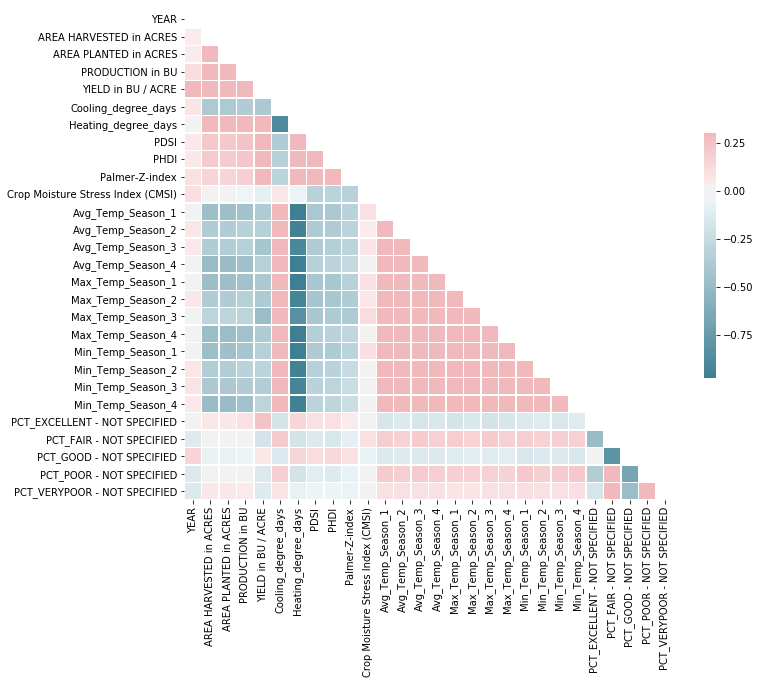

In [595]:
import seaborn as sns
import matplotlib.pyplot as plt 
#for col in merged_df.columns: print(col)
# Generate a mask for the upper triangle
corr = merged_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [490]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [492]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(missing_values_table(merged_df))

Your selected dataframe has 960 columns.
There are 958 columns that have missing values.


,Missing Values,% of Total Values
"APPLICATIONS in LB / ACRE / APPLICATION, AVG - CHEMICAL, HERBICIDE: (EPTC = 41401)",840,99.9
"APPLICATIONS in LB / ACRE / APPLICATION, AVG - CHEMICAL, HERBICIDE: (NICOSULFURON = 129008)",840,99.9
"APPLICATIONS in LB / ACRE / YEAR, AVG - CHEMICAL, HERBICIDE: (2,4-D, TRIISO. SALT = 30035)",840,99.9
"APPLICATIONS in NUMBER, AVG - CHEMICAL, HERBICIDE: (PROPACHLOR = 19101)",840,99.9
"APPLICATIONS in NUMBER, AVG - CHEMICAL, HERBICIDE: (PRODIAMINE = 110201)",840,99.9
"APPLICATIONS in NUMBER, AVG - CHEMICAL, INSECTICIDE: (ABAMECTIN = 122804)",840,99.9
"APPLICATIONS in LB / ACRE / APPLICATION, AVG - CHEMICAL, FUNGICIDE: (ZOXAMIDE = 101702)",840,99.9
"APPLICATIONS in LB - CHEMICAL, HERBICIDE: (DIURON = 35505)",840,99.9
"APPLICATIONS in LB - CHEMICAL, HERBICIDE: (EPTC = 41401)",840,99.9
"APPLICATIONS in LB / ACRE / YEAR, AVG - CHEMICAL, FUNGICIDE: (ZOXAMIDE = 101702)",840,99.9
